# Part 4: Gene expression

This notebook generates the items listed below. For preprocessing see:

Figures: 
* Figure 4 panels b-f

Supplementary Tables:
* Supp Table 12: significant eTRs in EUR
* Supp Table 13: significant eTRs in AFR
* Supp Dataset 1: all eTR summary stats

Statistics:
* How many eTRs were identified here but not in GTEx

In [1]:
####### Set up #########
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

PLOTDIR = "pdfs"

Populating the interactive namespace from numpy and matplotlib


# Data preparation

In [2]:
######## Load and preprocess data #######
eur = pd.read_csv("/storage/yal084/geuvidas_eQTL/results/EUR_eSTR_regression_with_gender.csv", sep="\t")
afr = pd.read_csv("/storage/yal084/geuvidas_eQTL/results/AFR_eSTR_regression_with_gender.csv", sep="\t")

def PreprocessExprDF(df):
    print("***** Before processing: %s"%df.shape[0])
    # Add chrom,start columns
    df["chrom"] = df["str-gene"].apply(lambda x: (x.split("_")[0]))
    df["start"] = df["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
    df["ens_gene"] = df["str-gene"].apply(lambda x: x.split("-")[-1])

    # basic filtering
    df = df[(df["sample_n"]>=50) & ~np.isnan(df["p_values"])].copy()
    print("***** After filtering by sample and NA pval: %s"%df.shape[0])

    # Remove near duplicates (STR within 20bp of each other)
    R=20
    df["start_rounded"] = df["start"].apply(lambda x: int(x/R)*R)
    df = df.loc[df.groupby(['chrom','start_rounded','gene_name'])['p_values'].idxmin()].copy()
    df = df.drop(["start_rounded"], axis=1)
    print("***** After dropping duplicates: %s"%df.shape[0])
    return df

# Preprocess
eur = PreprocessExprDF(eur)
afr = PreprocessExprDF(afr)

***** Before processing: 664716
***** After filtering by sample and NA pval: 664716
***** After dropping duplicates: 661751
***** Before processing: 673000
***** After filtering by sample and NA pval: 672495
***** After dropping duplicates: 669599


In [3]:
######## Perform multiple hypothesis correction #######

FDRTHRESH = 0.05

def GetGeneLevelFDR(df, fdrthresh=0.05):
    print("***** Starting with this many STR*gene pairs: %s"%df.shape[0])

    ##### Bonferroni adjusted for number of STRs tested #####
    bygene = df.groupby(["gene_name"], as_index=False).agg({"str-gene": len})
    bygene = bygene.rename({"str-gene": "num.strs.tested"}, axis=1)
    print("***** Num. genes for Bonferroni correction: %s"%bygene.shape[0])
    # merge back to main df
    xx = pd.merge(df, bygene[["gene_name","num.strs.tested"]], on=["gene_name"])
    xx["genelevel.bf.adj.p"] = xx.apply(lambda x: np.min([1, x["p_values"]*x["num.strs.tested"]]), 1)
    print("***** This many STR*gene pairs after merging back num.strs.tested: %s"%xx.shape[0])

    ##### Find the best STR per gene and do FDR on that #####
    bestps = xx.groupby(["gene_name"], as_index=False).agg({"genelevel.bf.adj.p": np.min})
    bestps["best.genelevel.p.adj"] = \
        statsmodels.stats.multitest.multipletests(list(bestps["genelevel.bf.adj.p"]), \
                                                  method="fdr_bh")[1]
    bestps = bestps.rename({"genelevel.bf.adj.p": "best.genelevel.bf.adj.p"}, axis=1)
    print("***** Num. genes for gene-level FDR: %s"%bygene.shape[0])

    # Merge back to main df
    xx = pd.merge(xx, bestps, on=["gene_name"])
    xx["best.str"] = (xx["genelevel.bf.adj.p"]==xx["best.genelevel.bf.adj.p"])
    print("***** This many STR*gene pairs after merging back bestps: %s"%xx.shape[0])

    ###### Determine significance ######
    xx["sig.genelevel"] = xx.apply(lambda x: x["best.str"] and (x["best.genelevel.p.adj"]<fdrthresh), 1)
    
    ###### Resolve duplicates (gene with multiple best TRs, arbitrarily choose one with min start coord)
    dups = xx[xx["sig.genelevel"]].groupby(["gene_name"], as_index=False).agg({"start": min, "chrom": len})
    dups = dups.rename({"chrom": "num.best", "start": "min.best.start"}, axis=1)
    xx = pd.merge(dups, xx, on=["gene_name"], how="outer")
    xx.loc[(xx["sig.genelevel"]) & (xx["num.best"]>1) & (xx["start"]!=xx["min.best.start"]), "best.str"] = False
    xx.loc[(xx["sig.genelevel"]) & (xx["num.best"]>1) & (xx["start"]!=xx["min.best.start"]), "sig.genelevel"] = False    
    print("***** This many STR*gene pairs after merging back dups: %s"%xx.shape[0])
    
    ##### Return results #######
    print("Number of gene-level: %s"%(np.sum(xx["sig.genelevel"])))
    return xx

def PerformFDR(df, prefix="None", fdrthresh=0.05):
    print("############ %s #########"%prefix)
    #### Gene-level FDR ####
    df = GetGeneLevelFDR(df, fdrthresh=fdrthresh)
    #### Pairwise gene*STR FDR ###
    df["geuvadis.TRlevel.padj"] = statsmodels.stats.multitest.multipletests(list(df["p_values"]), method="fdr_bh")[1]
    print("Number of TR level: %s"%df[df["geuvadis.TRlevel.padj"]<FDRTHRESH].shape[0])
    return df

eur_fdr = PerformFDR(eur, prefix="EUR", fdrthresh=FDRTHRESH)
afr_fdr = PerformFDR(afr, prefix="AFR", fdrthresh=FDRTHRESH)

############ EUR #########
***** Starting with this many STR*gene pairs: 661751
***** Num. genes for Bonferroni correction: 12594
***** This many STR*gene pairs after merging back num.strs.tested: 661751
***** Num. genes for gene-level FDR: 12594
***** This many STR*gene pairs after merging back bestps: 661751
***** This many STR*gene pairs after merging back dups: 661751
Number of gene-level: 3644
Number of TR level: 55361
############ AFR #########
***** Starting with this many STR*gene pairs: 669599
***** Num. genes for Bonferroni correction: 12594
***** This many STR*gene pairs after merging back num.strs.tested: 669599
***** Num. genes for gene-level FDR: 12594
***** This many STR*gene pairs after merging back bestps: 669599
***** This many STR*gene pairs after merging back dups: 669599
Number of gene-level: 72
Number of TR level: 342


In [4]:
###### Merge AFR/EUR for comparison and supp dataset#######
cols = ["chrom","start","gene_name","ens_gene","sample_n","p_values","slope","error","geuvadis.TRlevel.padj","best.str","sig.genelevel","best.genelevel.p.adj"]
all_geuvadis = pd.merge(eur_fdr[cols], afr_fdr[cols], on=["chrom","start","gene_name","ens_gene"], suffixes=("_EUR", "_AFR"), how="outer")

## Preprocessing for Figure 4c-d: Comparison of effect sizes in GEUVADIS vs. GTEx

In [5]:
# List of Tissues that analyzed in GTEx data
TISSUES = [
    "Adipose-Subcutaneous",
    "Adipose-Visceral",
    "Artery-Aorta",
    "Artery-Tibial",
    "Brain-Caudate",
    "Brain-Cerebellum",
    "Cells-Transformedfibroblasts",
    "Esophagus-Mucosa",
    "Esophagus-Muscularis",
    "Heart-LeftVentricle",
    "Lung",
    "Muscle-Skeletal",
    "Nerve-Tibial",
    "Skin-NotSunExposed",
    "Skin-SunExposed",
    "Thyroid",
    "WholeBlood"
]

###### Load GTEx data ###########
def LoadTissue(t, verbose=False):
    if verbose: print("***** %s"%t)
    df = pd.read_csv("../geuvadis/raw/master/%s_master.tab"%t, sep="\t",low_memory=False)
    if verbose: print("***** Loaded %s rows"%df.shape[0])
    lift = pd.read_csv("../geuvadis/liftover/%s_hg38.bed"%t, 
                       sep="\t", names=["chrom","start_hg38","x","hg19_coords"])
    lift["str.start"] = lift["hg19_coords"].apply(lambda x: int(x.split(":")[1]))
    lift = lift.drop_duplicates()
    df = pd.merge(df, lift[["chrom","str.start","start_hg38"]], on=["chrom","str.start"])
    df = df.rename({"gene.name": "gene_name"}, axis=1)
    if verbose: print("***** Lifted over %s rows"%df.shape[0])

    # Remove STRs both p.val and beta is null
    df = df[(~df["linreg.pval"].isnull()) & (~df["linreg.beta"].isnull())]
    if verbose: print("***** After removing NA have %s rows"%df.shape[0])

    # Get eTR-level adjusted pvals
    df["gtex.TRlevel.padj"] = statsmodels.stats.multitest.multipletests(list(df["linreg.pval"]), \
                                                     method="fdr_bh")[1]
    return df

def MergeGTExGeuvadis(gtex, geu, verbose=False):
    if verbose: print("***** Started with %s gtex and %s geu"%(gtex.shape[0], geu.shape[0]))
    # Round coordinates in case off by a bit
    R = 20
    geu["start_hg38"] = geu["start"]
    geu["start_hg38_rounded"] = geu["start_hg38"].apply(lambda x: int(x/R)*R)
    gtex["start_hg38_rounded"] = gtex["start_hg38"].apply(lambda x: int(x/R)*R)
    # Merge on rounded coords and gene
    merged = pd.merge(geu[["chrom","start_hg38_rounded","start_hg38","gene_name","slope","p_values","geuvadis.TRlevel.padj"]], \
                        gtex[["chrom","start_hg38_rounded","gene_name","linreg.beta","linreg.pval","gtex.TRlevel.padj"]])
    merged = merged[~np.isnan(merged["linreg.beta"]) & ~np.isnan(merged["slope"])]
    if verbose: print("***** After merging: %s"%(merged.shape[0]))

    # Require some significance threshold in GEUVADIS
    merged = merged[(merged["geuvadis.TRlevel.padj"]<FDRTHRESH)]
    
    if verbose: print("***** After significance filtering: %s"%(merged.shape[0]))
    return merged

gtex = {} # tissue -> df
r_eur_ = []
r_afr_ = []
p_eur_ = []
p_afr_ = []
n_eur_ = []
n_afr_ = []

for t in TISSUES:
    gtex[t] = LoadTissue(t)
    eur_merged = MergeGTExGeuvadis(gtex[t], eur_fdr)
    afr_merged = MergeGTExGeuvadis(gtex[t], afr_fdr)
    r_eur, p_eur = scipy.stats.pearsonr(eur_merged["slope"], eur_merged["linreg.beta"])
    r_afr, p_afr = scipy.stats.pearsonr(afr_merged["slope"], afr_merged["linreg.beta"])
    n_eur = eur_merged.shape[0]
    n_afr = afr_merged.shape[0]
    r_eur_.append(r_eur)
    p_eur_.append(p_eur)
    n_eur_.append(n_eur)
    r_afr_.append(r_afr)
    p_afr_.append(p_afr)
    n_afr_.append(n_afr)
gtex_summ = pd.DataFrame({
    "tissue": TISSUES,
    "r_eur": r_eur_,
    "p_eur": p_eur_,
    "n_eur": n_eur_,
    "r_afr": r_afr_,
    "p_afr": p_afr_,
    "n_afr": n_afr_
})
gtex_summ.sort_values("r_eur")

,tissue,r_eur,p_eur,n_eur,r_afr,p_afr,n_afr
5,Brain-Cerebellum,0.357445,0.0,13084,0.668957,5.751832e-13,90
4,Brain-Caudate,0.388761,0.0,13173,0.705103,1.743555e-14,88
11,Muscle-Skeletal,0.469805,0.0,14219,0.734105,1.180906e-17,97
9,Heart-LeftVentricle,0.474512,0.0,13872,0.685219,2.585370e-14,94
12,Nerve-Tibial,0.478558,0.0,14354,0.762239,2.908893e-19,95
15,Thyroid,0.490512,0.0,14351,0.763259,1.009558e-19,97
13,Skin-NotSunExposed,0.495003,0.0,14199,0.696858,4.402991e-15,95
3,Artery-Tibial,0.499283,0.0,14212,0.744209,3.670282e-18,96
2,Artery-Aorta,0.500072,0.0,13992,0.745703,1.500981e-17,92
14,Skin-SunExposed,0.504172,0.0,14418,0.704115,6.074439e-16,98


## Setup for Figure 4e-f: Example eTRs

In [6]:
AFR_COLOR = "red"
EUR_COLOR = "blue"
 
def get_str_exp_values(str_gene, pop='EUR', minsPgt=3):
    """
    input str-gene pairs and population
    extract the genotypes: sum of alleles output the expression 
    """
    
    chrom=str_gene.split('_')[0]
    pos=int(str_gene.split('-')[0].split('_')[1])
    gene_id=str_gene.split('-')[1]
    
    gt_dir='/storage/yal084/geuvidas_eQTL/ensemble_call/GB_info/'\
        +str(chrom)+'.GB.FORMAT'
    exp_df=pd.read_csv('/storage/yal084/geuvidas_eQTL/normalized_expression/'+pop+'_normalized_and_filtered_hg38.csv',sep='\t')
    exp_df=exp_df[exp_df.gene_id==gene_id]
    
    all_STR=pd.read_csv(gt_dir,sep='\t')
    select_STR=all_STR[all_STR.POS==pos].copy()
    select_STR[select_STR.columns[2:]]=select_STR[select_STR.columns[2:]]. \
                    applymap(lambda x: [int(x.split('/')[0]),int(x.split('/')[1])] if '/' in x else [None,None])
    select_STR=select_STR[['CHROM','POS']+select_STR.columns[2:][select_STR.iloc[0,2:].apply(lambda x: x !=[None,None])].to_list()]
    gt_samples=select_STR.columns[2:][select_STR.iloc[0,2:].apply(lambda x: x !=[None,None])].to_list()
    gt_samples=list(set(gt_samples) & set(exp_df.columns.tolist()))
    select_STR_phased=select_STR[gt_samples].T.rename \
                        (columns={select_STR.index.to_list()[0]:'GT'}).applymap(lambda x: sum(x))
    gt_sum=select_STR_phased.groupby('GT').size()
    gt_ab_3=gt_sum[gt_sum>=minsPgt].index.tolist()
    final_filted_samples=set(select_STR_phased[select_STR_phased.GT.isin(gt_ab_3)].index)
    final_phased_STR=select_STR_phased.loc[final_filted_samples].copy()
    
    return final_phased_STR.values.reshape(-1),exp_df[final_filted_samples].values.reshape(-1)

def GetSummary(gts, exprs):
    gtvals = sorted(list(set(gts)))
    evals = []
    for gtval in gtvals:
        evals.append(np.median([exprs[i] for i in range(len(exprs)) if gts[i]==gtval]))
    return gtvals, evals

def AddNoise(items):
    return [item + np.random.uniform(0, 0.1) for item in items]

def plot_eTR(str_gene,ax,motif,gene_name):
    afr_str, afr_expr = get_str_exp_values(str_gene,pop='AFR')
    eur_str, eur_expr = get_str_exp_values(str_gene,pop='EUR')

    afr_str_summ, afr_expr_summ = GetSummary(afr_str, afr_expr)
    eur_str_summ, eur_expr_summ = GetSummary(eur_str, eur_expr)

    buf = 0.5

    ax.scatter(AddNoise([item-buf for item in afr_str]),afr_expr,color=AFR_COLOR, alpha=0.2,s=20) 
    ax.plot(afr_str_summ, afr_expr_summ, color=AFR_COLOR, marker="o", label="AFR")
    ax.scatter(AddNoise([item+buf for item in eur_str]),eur_expr,color=EUR_COLOR, alpha=0.2,s=20) 
    ax.plot(eur_str_summ, eur_expr_summ, color=EUR_COLOR, marker="o", label="EUR")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.legend()
    ax.set_xlabel("bp diff from hg38")
    ax.set_ylabel("Normalized expression")
    ax.set_title("%s (%s)"%(gene_name, motif),fontsize=20)

# Plot: Figure 4 b-f "TRs associated with gene expression in LCLs"

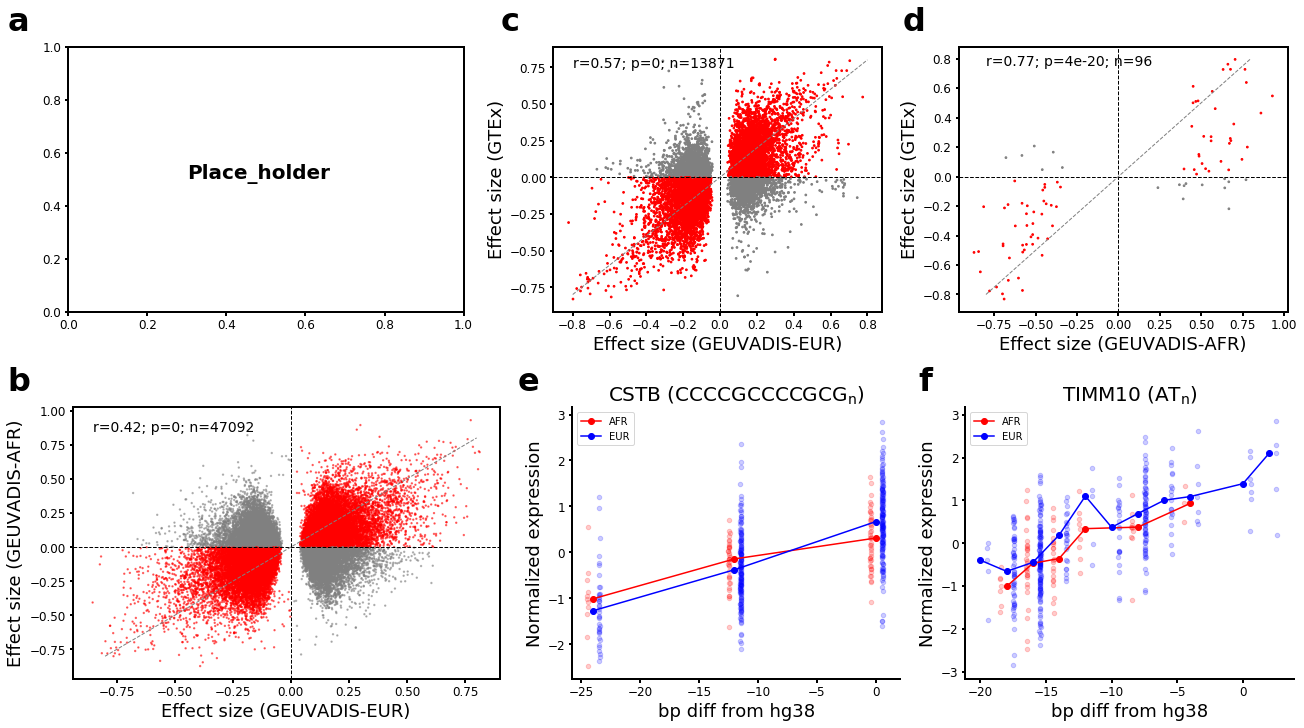

In [7]:
##### Set up figure and format axes #####
parameters = {'axes.labelsize': 18,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)

fig = plt.figure(constrained_layout=True)
fig.set_size_inches((18, 10))
gs = GridSpec(2, 3,width_ratios=[1.2,1,1], figure=fig)
gs0 = GridSpecFromSubplotSpec(1, 3, width_ratios=[1.3,1,1], subplot_spec=gs[1,:])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs0[0,0])
ax5 = fig.add_subplot(gs0[0,1])
ax6 = fig.add_subplot(gs0[0,2])    

sub_lenged=['a','c','d','b','e','f']

def GetColor(x, col1="slope_EUR", col2="slope_AFR"):
    if np.sign(x[col1])==np.sign(x[col2]):
        return "red"
    else: return "gray"
    
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        if i==0:
            ax.text(0.3, 0.5, "Place_holder", transform=ax.transAxes, 
                    size=20, fontweight="bold", family="sans-serif")
        #add f
        if i<6:
            labtext = sub_lenged[i]
            ax.text(-0.1, 1.15, labtext, transform=ax.transAxes, 
                         size=32, fontweight="bold", family="sans-serif",
                        va="top", ha="right")
            ax.tick_params(width=2)
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(2)

##### Figure 4b - EUR vs. AFR #####
# Only compare ones that were significant in at least EUR or ARF
fig4b_pltdata = all_geuvadis[((all_geuvadis["geuvadis.TRlevel.padj_EUR"]<FDRTHRESH) | (all_geuvadis["geuvadis.TRlevel.padj_AFR"]<FDRTHRESH)) &
                    (~np.isnan(all_geuvadis["slope_EUR"]) & ~np.isnan(all_geuvadis["slope_AFR"]))]

ax4.scatter(fig4b_pltdata["slope_EUR"], fig4b_pltdata["slope_AFR"], 
            color=fig4b_pltdata.apply(GetColor, 1), s=2, alpha=0.5);
ax4.axvline(x=0, linestyle="dashed", color="black", linewidth=1)
ax4.axhline(y=0, linestyle="dashed", color="black", linewidth=1)
ax4.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=1)
cor, p = scipy.stats.pearsonr(fig4b_pltdata["slope_EUR"], fig4b_pltdata["slope_AFR"])
n=fig4b_pltdata.shape[0]
ax4.text(-0.85, 0.85, "r=%.2f; p=%.2g; n=%s"%(cor, p, n), fontsize=14)
ax4.set_xlabel("Effect size (GEUVADIS-EUR)")
ax4.set_ylabel("Effect size (GEUVADIS-AFR)")

##### Figure 4c - gtex vs. Geuvadis (EUR) #####
t = "Cells-Transformedfibroblasts"
eur_merged = MergeGTExGeuvadis(gtex[t], eur_fdr)
afr_merged = MergeGTExGeuvadis(gtex[t], afr_fdr)

ax2.scatter(eur_merged["slope"], eur_merged["linreg.beta"], s=3, 
           color=eur_merged.apply(lambda x: GetColor(x, col1="slope", col2="linreg.beta"), 1))
ax2.axvline(x=0, linestyle="dashed", color="black", linewidth=1)
ax2.axhline(y=0, linestyle="dashed", color="black", linewidth=1)
ax2.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=1)
cor, p = scipy.stats.pearsonr(eur_merged["slope"], eur_merged["linreg.beta"])
n=eur_merged.shape[0]
ax2.text(-0.8, 0.75, "r=%.2f; p=%.2g; n=%s"%(cor, p, n), fontsize=14)
ax2.set_xlabel("Effect size (GEUVADIS-EUR)")
ax2.set_ylabel("Effect size (GTEx)")

##### Figure 4d - gtex vs. Geuvadis (AFR) #####
ax3.scatter(afr_merged["slope"], afr_merged["linreg.beta"], s=3, 
           color=afr_merged.apply(lambda x: GetColor(x, col1="slope", col2="linreg.beta"), 1))
ax3.axvline(x=0, linestyle="dashed", color="black", linewidth=1)
ax3.axhline(y=0, linestyle="dashed", color="black", linewidth=1)
ax3.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=1)
cor, p = scipy.stats.pearsonr(afr_merged["slope"], afr_merged["linreg.beta"])
n=afr_merged.shape[0]
ax3.text(-0.8, 0.75, "r=%.2f; p=%.2g; n=%s"%(cor, p, n), fontsize=14)
ax3.set_xlabel("Effect size (GEUVADIS-AFR)")
ax3.set_ylabel("Effect size (GTEx)")

##### Figure 4e-f examples #####
plot_eTR('chr21_43776443-ENSG00000160213.5',ax5,'CCCCGCCCCGCG$_\mathrm{n}$','CSTB')
plot_eTR('chr11_57528484-ENSG00000134809.4',ax6,'AT$_\mathrm{n}$','TIMM10')

##### add titles and formating #####
format_axes(fig)
fig.savefig(os.path.join(PLOTDIR, "Figure4.pdf"))

# Supplementary Tables 12-13

In [8]:
# Load motif info
motifs = pd.read_csv("../het-stats/motif_info.tab", sep="\t", names=["chrom", "start","period","motif"]).drop_duplicates()    

# Sometimes multiple STRs have the same start but different motifs
# concatenate those in one motif entry for now
def concat(x): return ",".join(list(x))
motifs = motifs.groupby(["chrom","start"]).agg({"motif": concat})

In [9]:
def GenerateSuppTable(df, motifs, fname):
    cols_to_print = ["chrom","start","motif","gene_name","ens_gene","slope","error","p_values", \
                         "sample_n","geuvadis.TRlevel.padj","best.str","sig.genelevel"]
    print("**** Num items before merge motif: %s"%df.shape[0])
    df_table = pd.merge(df, motifs, on=["chrom","start"])
    print("**** Num items after merge motif: %s"%df_table.shape[0])
    df_table = df_table[df_table["geuvadis.TRlevel.padj"]<FDRTHRESH].sort_values(["chrom","gene_name","start"])
    print("**** Num items after restrict to significant: %s"%df_table.shape[0])
    df_table[cols_to_print].to_csv(os.path.join(PLOTDIR, fname), index=False)
    
GenerateSuppTable(eur_fdr, motifs, "SuppTable12-EUR-eTRs.csv")
GenerateSuppTable(afr_fdr, motifs, "SuppTable13-AFR-eTRs.csv")

**** Num items before merge motif: 661751
**** Num items after merge motif: 661751
**** Num items after restrict to significant: 55361
**** Num items before merge motif: 669599
**** Num items after merge motif: 669599
**** Num items after restrict to significant: 342


# Supplementary Dataset 1 (all eTR summ stats)

In [10]:
sdata1 = pd.merge(all_geuvadis, motifs, on=["chrom","start"]).sort_values(["chrom","gene_name","start"])
sdata1.to_csv(os.path.join(PLOTDIR, "SuppDataset1.csv"), index=False)

# Determine novel eTRs in GEUVADIS vs. GTEx

In [80]:
# Keep track of which eTRs are (1) at least nominally significant (2) tested at all in GTEx
gtex_allTRs = set()
gtex_eTRs = set()

for t in TISSUES:
    xx = gtex[t]
    xx["ID"] = xx.apply(lambda x: "%s_%s_%s"%(x["chrom"], x["start_hg38_rounded"], x["gene_name"]), 1)
    gtex_allTRs = gtex_allTRs.union(set(xx["ID"]))
    gtex_eTRs = gtex_eTRs.union(set(xx[(xx["linreg.pval"]<0.05)]["ID"]))
    
# Get list of significant eTRs in either EUR or AFR
R = 20

# NOTE! If the NAs are not changed, then ones sig in one pop but NA in the other
# do not get into sig_geu
all_geuvadis.loc[all_geuvadis["sig.genelevel_EUR"].apply(lambda x: str(x)=="nan"), "sig.genelevel_EUR"] = False
all_geuvadis.loc[all_geuvadis["sig.genelevel_AFR"].apply(lambda x: str(x)=="nan"), "sig.genelevel_AFR"] = False
sig_geu = all_geuvadis[(all_geuvadis["sig.genelevel_EUR"]) |
            (all_geuvadis["sig.genelevel_AFR"])].copy()
sig_geu["start_hg38_rounded"] = sig_geu["start"].apply(lambda x: int(x/R)*R)
sig_geu["ID"] = sig_geu.apply(lambda x: "%s_%s_%s"%(x["chrom"], x["start_hg38_rounded"], x["gene_name"]), 1)
geu_eTRs = set(sig_geu["ID"])

In [81]:
print("Total number in GEUVADIS: %s"%len(geu_eTRs))
print("Total number NEW in GEUVADIS: %s. Of these:"%len(geu_eTRs-gtex_eTRs))
print("***Number in geuvadis not tested in GTEx: %s"%(len(geu_eTRs - gtex_allTRs)))
print("***Number in geuvadis tested but not significant in GTEx: %s"%(len((geu_eTRs.intersection(gtex_allTRs)) - gtex_eTRs)))

Total number in GEUVADIS: 3695
Total number NEW in GEUVADIS: 2777. Of these:
***Number in geuvadis not tested in GTEx: 2674
***Number in geuvadis tested but not significant in GTEx: 103
